Import Data:

In [1]:
import pandas as pd
import numpy as np
import datetime
pd.set_option('display.max_columns', 999)
import pandas.io.sql as psql
# plot a figure directly on Notebook
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

[nltk_data] Downloading package punkt to /Users/kobo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from os.path import exists
data_dir = '/Users/kobo/Documents/aiforhealth/AIForHealth_V-A/data/mimic-iii-clinical-database-1.4'

In [3]:
admissions = pd.read_csv(f'{data_dir}/ADMISSIONS.csv.gz', compression='gzip', low_memory=False)
note_events = pd.read_csv(f'{data_dir}/NOTEEVENTS.csv')
patients = pd.read_csv(f'{data_dir}/PATIENTS.csv')

# admissions = pd.read_csv("demo-data/ADMISSIONS.csv")
# diagnoses = pd.read_csv("demo-data/DIAGNOSES_ICD.csv")
# patients = pd.read_csv("demo-data/PATIENTS.csv")

print("Admissions Table\t" + str(admissions.shape))
print(admissions.columns)
# print("\nDiagnoses Table\t\t" + str(diagnoses.shape))
# print(diagnoses.columns)
print("\nPatients Table\t\t" + str(patients.shape))
print(patients.columns)
print("\nNote Events Table\t\t" + str(note_events.shape))
print(note_events.columns)

/var/folders/8g/mc6q7d1x28n5v1v_c5nv73cw0000gn/T/ipykernel_97006/151477038.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  note_events = pd.read_csv(f'{data_dir}/NOTEEVENTS.csv')


Admissions Table	(58976, 19)
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

Patients Table		(46520, 8)
Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object')

Note Events Table		(2083180, 11)
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT'],
      dtype='object')


In [4]:
# Merge Tables
# merged = admissions.merge(patients, on="SUBJECT_ID").merge(diagnoses, 
#             left_on=["SUBJECT_ID","HADM_ID"], right_on=["SUBJECT_ID","HADM_ID"])
merged = admissions

#
# PROBLEM: there are multiple entries now for one admission time, each entry represents a different diagnoses
    # Counts for diagnoses for one admittime range from 1 to 57
        # print(merged['ADMITTIME'].value_counts())
# Possible Fixes: merge them all together and make a new column that holds each diagnoses in an array

# Convert time to objects
merged["ADMITTIME"] = pd.to_datetime(merged["ADMITTIME"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
merged["DISCHTIME"] = pd.to_datetime(merged["DISCHTIME"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
merged["DEATHTIME"] = pd.to_datetime(merged["DISCHTIME"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

merged = merged.sort_values(['SUBJECT_ID','ADMITTIME'])
merged = merged.reset_index(drop = True)

merged['NEXT_ADMITTIME'] = merged.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
merged['NEXT_ADMISSION_TYPE'] = merged.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [5]:
len(merged['NEXT_ADMITTIME'].unique())

12451

In [6]:
rows = merged.NEXT_ADMISSION_TYPE == 'ELECTIVE'
merged.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
merged.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN
len(merged['NEXT_ADMITTIME'].unique())

11048

In [7]:
merged = merged.sort_values(['SUBJECT_ID','ADMITTIME'])
merged[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = merged.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [8]:
merged['NEXT_ADMITTIME'].unique()

<DatetimeArray>
[                'NaT', '2135-05-09 14:11:00', '2135-01-30 20:50:00',
 '2157-10-18 19:34:00', '2191-02-23 05:23:00', '2131-05-12 19:49:00',
 '2119-01-04 18:12:00', '2157-12-02 00:45:00', '2174-01-04 22:21:00',
 '2196-04-14 04:02:00',
 ...
 '2191-08-03 19:11:00', '2191-12-23 01:03:00', '2133-08-01 19:20:00',
 '2125-11-01 00:00:00', '2197-06-16 03:01:00', '2197-07-03 02:24:00',
 '2182-07-03 19:50:00', '2201-05-15 13:12:00', '2157-01-05 17:27:00',
 '2157-02-16 17:31:00']
Length: 11048, dtype: datetime64[ns]

In [9]:
merged['DAYS_NEXT_ADMIT']=(merged.NEXT_ADMITTIME - merged.DISCHTIME).dt.total_seconds()/(24*60*60)
merged['DAYS_STAY'] = (merged.DISCHTIME - merged.ADMITTIME).dt.total_seconds()/(24*60*60)
merged

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,DAYS_STAY
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,3.863889
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,NaN,NaN,10.784722
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,NaN,NaN,7.759028
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,2.322222
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,NaN,NaN,16.364583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58972,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,2181-02-12 17:05:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,JEWISH,MARRIED,WHITE,2181-01-26 23:35:00,2181-01-27 04:18:00,FEVER,0,1,NaT,NaN,NaN,16.595833
58972,58973,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,2185-01-05 12:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,DIVERTICULITIS/SDA,0,1,NaT,NaN,NaN,12.156250
58973,58974,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,2144-07-28 17:56:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2144-07-25 13:40:00,2144-07-25 18:50:00,RETROPERITONEAL HEMORRHAGE,0,1,NaT,NaN,NaN,2.995139
58974,58975,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,2147-02-11 13:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,NaT,NaN,NaN,3.218750


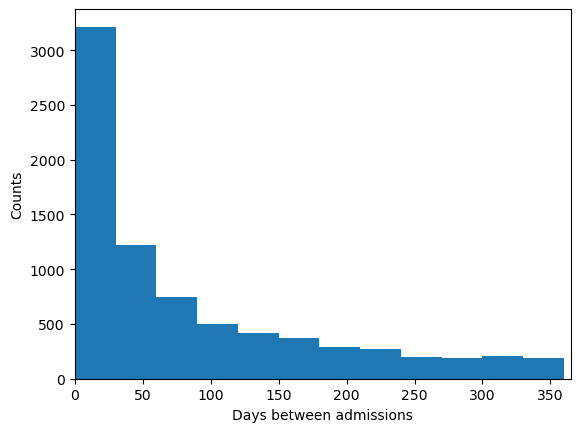

In [10]:
plt.hist(merged.loc[~merged.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

In [11]:
# For all 'CATEGORY' = 'Discharge summary':
    #'DESCRIPTION': ['Addendum', 'Report']        *Do we care if Addendum vs. Report? Addendum seems to have more information than initial Report but also some different info like Service:"" 
    #'CGID': NaN
    #'ISERROR': NaN
    
# could use all categories of notes by concatenating them if we wanted.

discharge_notes = note_events[note_events['CATEGORY']=='Discharge summary']
unique_discharge_notes = discharge_notes.groupby(['SUBJECT_ID','HADM_ID']).nth(-1).reset_index()
unique_discharge_notes.duplicated(['HADM_ID']).sum() == 0

True

In [12]:
merged = merged.merge(unique_discharge_notes[['SUBJECT_ID', 'HADM_ID', 'TEXT']], on=['SUBJECT_ID', 'HADM_ID'], how='left')

In [13]:
merged = merged.merge(patients[['SUBJECT_ID', 'DOB', 'GENDER']], on=['SUBJECT_ID'], how='left')

In [14]:
#Calculate age

merged['DOB'] = pd.to_datetime(merged["DOB"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
merged['ADMITTIME'] = pd.to_datetime(merged['ADMITTIME'])
merged['DOB']
merged['AGE'] = ((merged['ADMITTIME'].values  - merged['DOB'].values).astype(int)/8.64e13//365).astype(int)


In [15]:
merged

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,DAYS_STAY,TEXT,DOB,GENDER,AGE
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,3.863889,NaN,2138-07-17,M,0
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,NaN,NaN,10.784722,Admission Date: [**2101-10-20**] Discharg...,2025-04-11,M,76
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,NaN,NaN,7.759028,Admission Date: [**2191-3-16**] Discharge...,2143-05-12,F,47
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,2.322222,NaN,2103-02-02,M,0
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,NaN,NaN,16.364583,Admission Date: [**2175-5-30**] Dischar...,2109-06-21,F,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58972,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,2181-02-12 17:05:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,JEWISH,MARRIED,WHITE,2181-01-26 23:35:00,2181-01-27 04:18:00,FEVER,0,1,NaT,NaN,NaN,16.595833,Admission Date: [**2181-1-27**] ...,2127-04-08,M,53
58972,58973,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,2185-01-05 12:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,DIVERTICULITIS/SDA,0,1,NaT,NaN,NaN,12.156250,Admission Date: [**2184-12-24**] ...,2137-04-07,M,47
58973,58974,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,2144-07-28 17:56:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2144-07-25 13:40:00,2144-07-25 18:50:00,RETROPERITONEAL HEMORRHAGE,0,1,NaT,NaN,NaN,2.995139,Admission Date: [**2144-7-25**] ...,2078-10-17,F,65
58974,58975,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,2147-02-11 13:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,NaT,NaN,NaN,3.218750,Admission Date: [**2147-2-8**] D...,2058-05-29,F,88


In [16]:
print(merged.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/merged.groupby('ADMISSION_TYPE').size())
merged[merged['ADMISSION_TYPE'] != 'NEWBORN'].groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/merged.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64


ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN           NaN
URGENT       0.042665
dtype: float64

In [47]:
df = pd.DataFrame(merged)
df['ROW_ID'].astype(float)
df['SUBJECT_ID'].astype(float)
df['HADM_ID'].astype(float)
# get the column names
feature_names = df.columns.tolist()
# print the feature names
print(feature_names)

['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME', 'NEXT_ADMISSION_TYPE', 'DAYS_NEXT_ADMIT', 'DAYS_STAY', 'TEXT', 'DOB', 'GENDER', 'AGE', 'READMISSION']


In [50]:
pd.to_numeric(df['ROW_ID'], errors='coerce')
df[pd.to_numeric(df['ROW_ID'], errors='coerce').isna()]['ROW_ID']

Series([], Name: ROW_ID, dtype: int64)

In [17]:
merged['READMISSION'] = (merged.DAYS_NEXT_ADMIT < 30).astype('int')
merged['READMISSION'].value_counts()

READMISSION
0    55749
1     3227
Name: count, dtype: int64

In [18]:
shuffled_merged = merged.sample(n = len(merged), random_state = 42)
shuffled_merged = shuffled_merged.reset_index(drop = True)

# Save 30% of the data as validation and test data 
valid_and_test_data = merged.sample(frac=0.30,random_state=42)
test_data = valid_and_test_data.sample(frac = 0.5, random_state = 42)
valid_data = valid_and_test_data.drop(test_data.index)

# use the rest of the data as training data
train_data = shuffled_merged.drop(valid_and_test_data.index)

print(merged.shape)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)
print(str(test_data.shape[0] + valid_data.shape[0] + train_data.shape[0]))

(58976, 28)
(8846, 28)
(8847, 28)
(41283, 28)
58976


In [19]:
# There are a much larger amount of 0 labels than 1 labels (see merged['READMISSION'] counts)
# To solve this class imbalance, we randomly sample from the majority class (0 labels) an amount of data points equal to the minority class

# Split data by label
pos_train = train_data.loc[train_data['READMISSION'] == 1]
neg_train = train_data.loc[train_data['READMISSION'] != 1]

# Randomly sample data
sample_neg_train = neg_train.sample(n = len(pos_train), random_state = 42)

# Recombine Data
train_data = pd.concat([pos_train, sample_neg_train], axis = 0)
train_data = train_data.sample(n = len(train_data), random_state = 42).reset_index(drop = True)

In [20]:
print(train_data.shape)
print(sample_neg_train.shape)
print(pos_train.shape)

(4510, 28)
(2255, 28)
(2255, 28)


NLP processing on 'TEXT' column for discharge summaries from NOTE EVENTS TABLE

In [21]:
# Clean the string representation for 'TEXT' columns

train_data['TEXT'] = train_data['TEXT'].fillna(' ').str.replace('\n',' ').replace('\r',' ')
test_data['TEXT'] = test_data['TEXT'].fillna(' ').str.replace('\n',' ').replace('\r',' ')
valid_data['TEXT'] = valid_data['TEXT'].fillna(' ').str.replace('\n',' ').replace('\r',' ')

In [22]:
# import string
# def tokenizer_better(text):
#     # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
#     punc_list = string.punctuation+'0123456789'
#     t = str.maketrans(dict.fromkeys(punc_list, " "))
#     text = text.lower().translate(t)
#     tokens = nltk.word_tokenize(text)
#     return tokens

In [23]:
# Write tokenizer that removes non-words
tokenizeText = lambda x: nltk.tokenize.RegexpTokenizer(r'\b[a-zA-Z_]+\b').tokenize(x.lower())

sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']
vect = CountVectorizer(tokenizer = tokenizeText)
vect.fit(sample_text)
# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)
X.toarray()

/Users/kobo/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array([[1, 0, 2, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0]])

In [24]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                 'from','there','an','that','p','are','have','has','h','but','o',
                 'namepattern','which','every','also']

vect = CountVectorizer(max_features = 3000, tokenizer = tokenizeText, stop_words = my_stop_words)
# this could take a while
vect.fit(train_data['TEXT'].values)

CountVectorizer(max_features=3000,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                tokenizer=<function <lambda> at 0x173beb380>)

In [25]:
X_train = vect.transform(train_data['TEXT'].values)
X_valid = vect.transform(valid_data['TEXT'].values)

y_train = train_data['READMISSION']
y_valid = valid_data['READMISSION']

RANDOM FOREST REGRESSOR

In [27]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier()

# Instantiate model with 1000 decision trees
rf.matrix= RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

# fit <- randomForest(...)
# round(importance(fit), 2)

In [29]:
X_test = vect.transform(test_data['TEXT'].values)
y_test = test_data['READMISSION']
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for X_test:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error for X_test: 0.35 degrees.


In [30]:
predictions = rf.predict(X_train)
# Calculate the absolute errors
errors = abs(predictions - y_train)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for X_train:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error for X_train: 0.03 degrees.


In [33]:
# model_rf = rf
# y_train_preds_rf = model_rf.predict_proba(X_train)[:,1]
# y_valid_preds_rf = model_rf.predict_proba(X_valid)[:,1]
# X_test_rf = vect.transform(test_data['TEXT'].values)
# y_test_rf = test_data['READMISSION']
# y_test_preds_rf = model_rf.predict_proba(X_test)[:,1]
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
# from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score
# auroc= accuracy_score(rf.predict(X_test), y_test)
# print(auroc)


0.8661437515430115

K-NEAREST NEIGHBORS

In [59]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [60]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)#The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric.
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [61]:

y_pred = classifier.predict(X_test)

In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[4983 3395]
 [ 164  304]]


0.5976712638480669

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions

In [76]:
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt


def plot_correlation(data):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    # init figure size
    rcParams['figure.figsize'] = 15, 20
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()

# plot correlation & densities
plot_correlation(merged)

ValueError: could not convert string to float: 'NEWBORN'

<Figure size 1500x2000 with 0 Axes>

In [73]:
for i in [1,5,20,30,40,80]:
    knn_comparison(merged, i)

KeyError: "None of [Index(['X', 'Y'], dtype='object')] are in the [columns]"

In [64]:
# from matplotlib.colors import ListedColormap
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# classifier.fit(X_test, y_test)
# X_set, y_set = sc.inverse_transform(X_test), y_test
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 1),
#                      np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 1))
# plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('K-NN (Test set)')
# plt.xlabel('Age')
# plt.ylabel('Estimated Salary')
# plt.legend()
# plt.show()

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [52]:

# from math import sqrt
# class KNN():
#   def __init__(self,k):
#     self.k=k
#     print(self.k)
#   def fit(self,X_train,y_train):
#     self.x_train=X_train
#     self.y_train=y_train
#   def calculate_euclidean(self,sample1,sample2):
#     distance=0.0
#     for i in range(len(sample1)):
#       distance+=(sample1[i]-sample2[i])**2 #Euclidean Distance = sqrt(sum i to N (x1_i – x2_i)^2)
#     return sqrt(distance)
#   def nearest_neighbors(self,test_sample):
#     distances=[]#calculate distances from a test sample to every sample in a training set
#     for i in range(len(self.x_train)):
#       distances.append((self.y_train[i],self.calculate_euclidean(self.x_train[i],test_sample)))
#     distances.sort(key=lambda x:x[1])#sort in ascending order, based on a distance value
#     neighbors=[]
#     for i in range(self.k): #get first k samples
#       neighbors.append(distances[i][0])
#     return neighbors
#   def predict(self,test_set):
#     predictions=[]
#     for test_sample in test_set:
#       neighbors=self.nearest_neighbors(test_sample)
#       labels=[sample for sample in neighbors]
#       prediction=max(labels,key=labels.count)
#       predictions.append(prediction)
#     return predictions


In [51]:
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(feature_names)

# x = scaled
# y = df.iloc[:,-1].values

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
# k=5
# knn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_train)
# dist, indices = knn.kneighbors(X_test)
# y_pred=[]
# for i in range(len(X_test)):
#     d={0:0,1:1}
#     for j in range(k):
#         d[y_train[indices[i][j]]]+=1
#     Key_max = max(zip(d.values(), d.keys()))[1]  
#     y_pred.append(Key_max)
# y_pred= np.array(y_pred)
# accuracy_score(y_test,y_pred)

ValueError: could not convert string to float: 'ROW_ID'

LOGISTIC REGRESSION

In [26]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf.fit(X_train, y_train)

model = clf
y_train_preds = model.predict_proba(X_train)[:,1]
y_valid_preds = model.predict_proba(X_valid)[:,1]

In [27]:
X_test = vect.transform(test_data['TEXT'].values)
y_test = test_data['READMISSION']
y_test_preds = model.predict_proba(X_test)[:,1]

train_acc = np.mean(y_train == (y_train_preds > 0.5))
valid_acc = np.mean(y_valid == (y_valid_preds > 0.5))
test_acc = np.mean(y_test == (y_test_preds > 0.5))
print(train_acc)
print(valid_acc)
print(test_acc)

0.7301552106430155
0.7281564372103538
0.7334388424146507


TRYING TO MAKE THE MODEL BETTER (UP UNTIL NOW IS JUST USING 'TEXT' COLUMN)

In [70]:
#** Trying with adding AGE **

# Extract the 'AGE' column and convert it to a sparse matrix
train_age_column = (train_data['AGE']).values.reshape(-1, 1)
valid_age_column = (valid_data['AGE']).values.reshape(-1, 1)
test_age_column = (test_data['AGE']).values.reshape(-1, 1)


# Concatenate days_stay_column with X horizontally (ADDING ON TO PREVIOUS DAYSTAY)
X_train_age = hstack((X_train, train_age_column))
X_valid_age = hstack((X_valid, valid_age_column))
X_test_age = hstack((X_test, test_age_column))

clf3=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf3.fit(X_train_age, y_train)
model3 = clf3

Y_train_age = model3.predict_proba(X_train_age)[:,1]
Y_valid_age = model3.predict_proba(X_valid_age)[:,1]
Y_test_age = model3.predict_proba(X_test_age)[:,1]

train_with_age_acc = np.mean(y_train == (Y_train_age > 0.5))
valid_with_age_acc = np.mean(y_valid == (Y_valid_age > 0.5))
test_with_age_acc = np.mean(y_test == (Y_test_age > 0.5))
print(train_with_age_acc)
print(valid_with_age_acc)
print(test_with_age_acc)

0.7319290465631929
0.728382502543235
0.7340040696359936


/Users/kobo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
#** Trying with adding DAYS_STAY **

# Extract the 'DAYS_STAY' column and convert it to a sparse matrix
train_days_stay = train_data['DAYS_STAY'].values.reshape(-1, 1)
valid_days_stay = valid_data['DAYS_STAY'].values.reshape(-1, 1)
test_days_stay = test_data['DAYS_STAY'].values.reshape(-1, 1)


# Concatenate days_stay_column with X horizontally
X_train_with_days_stay = hstack((X_train, train_days_stay))
X_valid_with_days_stay = hstack((X_valid, valid_days_stay))
X_test_with_days_stay = hstack((X_test, test_days_stay))

clf2=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf2.fit(X_train_with_days_stay, y_train)
model2 = clf2

y_train_with_days_stay_preds = model2.predict_proba(X_train_with_days_stay)[:,1]
y_valid_with_days_stay_preds = model2.predict_proba(X_valid_with_days_stay)[:,1]
y_test_with_days_stay_preds = model2.predict_proba(X_test_with_days_stay)[:,1]

train_with_daystay_acc = np.mean(y_train == (y_train_with_days_stay_preds > 0.5))
valid_with_daystay_acc = np.mean(y_valid == (y_valid_with_days_stay_preds > 0.5))
test_with_daystay_acc = np.mean(y_test == (y_test_with_days_stay_preds > 0.5))
print(train_with_daystay_acc)
print(valid_with_daystay_acc)
print(test_with_daystay_acc)

0.7339246119733924
0.7263479145473042
0.7326475243047705


In [38]:
print(train_with_daystay_acc - train_acc)
print(valid_with_daystay_acc - valid_acc)
print(test_with_daystay_acc - test_acc)

0.0037694013303769536
-0.0018085226630496498
-0.0007913181098802013


USING patient data (age, gender)

In [44]:
#** Trying with adding GENDER **

# Extract the 'GENDER' column and convert it to a sparse matrix
train_gender_column = (train_data['GENDER']=='M').values.reshape(-1, 1)
valid_gender_column = (valid_data['GENDER']=='M').values.reshape(-1, 1)
test_gender_column = (test_data['GENDER']=='M').values.reshape(-1, 1)


# Concatenate days_stay_column with X horizontally (ADDING ON TO PREVIOUS DAYSTAY)
newX_train = hstack((X_train_with_days_stay, train_gender_column))
newX_valid = hstack((X_valid_with_days_stay, valid_gender_column))
newX_test = hstack((X_test_with_days_stay, test_gender_column))

clf3=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf3.fit(newX_train, y_train)
model3 = clf3

newy_train = model3.predict_proba(newX_train)[:,1]
newy_valid = model3.predict_proba(newX_valid)[:,1]
newy_test = model3.predict_proba(newX_test)[:,1]

train_with_gender_acc = np.mean(y_train == (newy_train > 0.5))
valid_with_gender_acc = np.mean(y_valid == (newy_valid > 0.5))
test_with_gender_acc = np.mean(y_test == (newy_test > 0.5))
print(train_with_gender_acc)
print(valid_with_gender_acc)
print(test_with_gender_acc)

0.7348115299334812
0.7263479145473042
0.7333257969703821
